<a href="https://colab.research.google.com/github/xasthon/pandas-deneme/blob/main/monthly_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'doneprojects:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4560436%2F7790934%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240320%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240320T085011Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D383665d0bb9a202ace88d743ce3fb07aee7ed9f5a18233a65a6a2ada8c4521e5b63ce6729f8d43756d914a756e728247433967f0039308015d29859a2385dc1a5432e09559089c28a67055728bce1e413bb2494977f03d1207ee2e2f0eb7fdf2557851c64a24e5a9b1c9ce46dcefd42e573427d065e772b5e890f470658bf6c9cffbe95ad142e7099a4492995a091acead161d8e5c21d1e5c7d3d003d3d6b775121ea8ce9508df4a05011780b75f4036a30cad413d944245a3940192a60c2dac7f42b771d241cd9bf994985d116880edcf5f76022af6df3e46cf14fb58e5f1726367b99caf3b9971df7efb361c8ece7958a81169f6476a704d00f1eae903d19a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Project Overview

This project is designed to assist teams in forecasting and managing labor hours across the lifespan of various projects. By leveraging historical project data, the Python script provides an analytical framework to predict the distribution of labor hours for both new and ongoing projects. The core functionality is built around data manipulation and statistical interpolation techniques, enabling users to make informed decisions and optimize resource allocation.

# Objectives

* **Labor Hour Prediction:** Generate accurate predictions of labor hour distributions for new projects based on aggregated historical data.
* **Ongoing Project Analysis:** Offer insights and adjusted forecasts for ongoing projects, taking into account the work already completed and the total labor hours allocated.
* **Data-Driven Decision Making:** Plan, adjust, and allocate resources more effectively throughout the project lifecycle.

# Key Features

1. **Data Preparation and Aggregation:**
* Import and concatenate multiple datasets containing detailed records of past projects.
* Clean and preprocess data to ensure consistency and relevance for analysis.

2. **Historical Analysis:**
* Analyze historical project data to identify patterns and trends in labor hour distribution.
* Group data by project and time period to facilitate detailed analysis.

3. **Labor Hour Forecasting:**
* Implement statistical models to forecast labor hours for new projects based on historical trends.
* Provide adjusted predictions for ongoing projects, incorporating actual labor hours spent to refine forecasts.

4. **User Interaction:**
* Offer a user-friendly menu-driven interface for selecting the prediction model (new or ongoing project).
* Collect input from users regarding project parameters (e.g., total duration, current progress, total labor hours).

5. **Visualization:**
* Generate various plots to visualize the predicted distribution of labor hours.

# Implementation Details

The project utilizes the Pandas library for data manipulation, the SciPy library for interpolation and statistical modeling, and Matplotlib for generating plots. It follows a modular approach, with distinct functions dedicated to specific tasks such as data preprocessing, prediction modeling, and visualization. This structure enhances the code's readability and maintainability.

# Flowchart
<img src="attachment:7d25f9e4-6ab3-43ce-b9eb-6dd2f13c0ca6.png" alt="drawing" width="500" height="auto"/>


# Conclusion

This Python-based project offers a tool for project labor hour prediction and analysis, historical data analysis with predictive modeling to support strategic planning and decision-making in project management.

In [ ]:
import numpy as np
import pandas as pd
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/doneprojects/done_project1.xlsx
/kaggle/input/doneprojects/done_project2.xlsx


In [ ]:
df_1 = pd.read_excel('/kaggle/input/doneprojects/done_project1.xlsx')
df_2 = pd.read_excel('/kaggle/input/doneprojects/done_project2.xlsx')

In [ ]:
concatenated_df = pd.concat([df_1, df_2], ignore_index=True)
concatenated_df

,,PROJECT_ID,SUB_PROJECT_ID,ACTIVITY_NO,ACCOUNT_DATE,REGISTERED_BY,EMP_NO,INTERNAL_QUANTITY,REPORT_COST_CODE,ORG_CODE
0,1,DURAMAX,DURAMAX,E_E CTRL,2019-03-25,AKURTULUS,01851,2.0,E01.1,810-505
1,2,DURAMAX,DURAMAX,E_E CTRL,2019-03-26,AKURTULUS,01851,2.0,E01.1,810-505
2,3,DURAMAX,DURAMAX,E_E CTRL,2019-03-28,AKURTULUS,01851,2.0,E01.1,810-505
3,4,DURAMAX,DURAMAX,E_E CTRL,2019-03-29,AKURTULUS,01851,1.0,E01.1,810-505
4,5,DURAMAX,DURAMAX,E_E CTRL,2019-03-30,AKURTULUS,01851,2.0,E01.1,810-505
...,...,...,...,...,...,...,...,...,...,...
84041,61068,ZMA4,ZMA4_ILS,ZMA4_ILS,2020-11-27,CEEROGLU,02071,1.0,ILS.10,8107043
84042,61069,ZMA4,ZMA4_ILS,ZMA4_ILS,2020-12-01,CEEROGLU,02071,3.0,ILS.10,8107043
84043,61070,ZMA4,ZMA4_ILS,ZMA4_ILS,2020-12-02,BKALENDER,02047,0.5,ILS.10,8107043
84044,61071,ZMA4,ZMA4_ILS,ZMA4_ILS,2020-12-02,CEEROGLU,02071,1.0,ILS.10,8107043


In [ ]:
filtered_df = concatenated_df[~concatenated_df['SUB_PROJECT_ID'].str.contains('_ILS')]
filtered_df

,,PROJECT_ID,SUB_PROJECT_ID,ACTIVITY_NO,ACCOUNT_DATE,REGISTERED_BY,EMP_NO,INTERNAL_QUANTITY,REPORT_COST_CODE,ORG_CODE
0,1,DURAMAX,DURAMAX,E_E CTRL,2019-03-25,AKURTULUS,01851,2.0,E01.1,810-505
1,2,DURAMAX,DURAMAX,E_E CTRL,2019-03-26,AKURTULUS,01851,2.0,E01.1,810-505
2,3,DURAMAX,DURAMAX,E_E CTRL,2019-03-28,AKURTULUS,01851,2.0,E01.1,810-505
3,4,DURAMAX,DURAMAX,E_E CTRL,2019-03-29,AKURTULUS,01851,1.0,E01.1,810-505
4,5,DURAMAX,DURAMAX,E_E CTRL,2019-03-30,AKURTULUS,01851,2.0,E01.1,810-505
...,...,...,...,...,...,...,...,...,...,...
84026,61053,ZMA4,ZMANONAMPH,3D_MODELLM,2020-10-21,VAVCI,00684,8.0,E13.1,81072112
84027,61054,ZMA4,ZMANONAMPH,3D_MODELLM,2020-10-22,VAVCI,00684,8.0,E13.1,81072112
84028,61055,ZMA4,ZMANONAMPH,3D_MODELLM,2020-10-23,VAVCI,00684,8.0,E13.1,81072112
84029,61056,ZMA4,ZMANONAMPH,3D_MODELLM,2020-10-26,VAVCI,00684,8.0,E13.1,81072112


In [ ]:
filtered_df.loc[:, 'ACCOUNT_DATE'] = pd.to_datetime(filtered_df['ACCOUNT_DATE'])
monthly_df = filtered_df.groupby(['PROJECT_ID', filtered_df['ACCOUNT_DATE'].dt.to_period('M')])['INTERNAL_QUANTITY'].sum().reset_index()
monthly_df['PROJECT_MONTH'] = monthly_df.groupby('PROJECT_ID').cumcount() + 1
monthly_df.head(45)

,PROJECT_ID,ACCOUNT_DATE,INTERNAL_QUANTITY,PROJECT_MONTH
0,DURAMAX,2018-02,9.00,1
1,DURAMAX,2018-03,20.00,2
2,DURAMAX,2018-04,27.00,3
3,DURAMAX,2018-05,20.00,4
4,DURAMAX,2018-06,11.50,5
5,DURAMAX,2018-07,86.50,6
6,DURAMAX,2018-08,12.00,7
7,DURAMAX,2018-09,75.00,8
8,DURAMAX,2018-10,11.00,9
9,DURAMAX,2018-11,8.00,10


In [ ]:
# Projelerin her biri için zamansal ölçeği 0'dan 1'e standartlaştırma
standardized_data = {}

for project_id in monthly_df['PROJECT_ID'].unique():
    project_data = monthly_df[monthly_df['PROJECT_ID'] == project_id]
    # Projeye ait aylık verileri sıralama
    project_data = project_data.sort_values(by='PROJECT_MONTH')
    # Her bir proje için toplam işçilik miktarını hesaplama
    total_quantities_by_project = project_data.groupby('PROJECT_ID')['INTERNAL_QUANTITY'].sum()
    # Normalleştirilmiş işçilik miktarını hesaplama
    project_data['TOTAL_QUANTITY'] = project_data['PROJECT_ID'].map(total_quantities_by_project)
    project_data['NORMALIZED_QUANTITY'] = project_data['INTERNAL_QUANTITY'] / project_data['TOTAL_QUANTITY']
    # Zamansal ölçeği 0'dan 1'e dönüştürme
    time_scale = list(range(1, len(project_data) + 1))
    standardized_time_scale = [t / max(time_scale) for t in time_scale]
    standardized_data[project_id] = (standardized_time_scale, project_data['NORMALIZED_QUANTITY'].tolist())

In [ ]:
def interpolate_project_curve(standardized_data, project_length):
    uniform_time_scale = np.linspace(0, 1, 100)
    interpolated_quantities = np.zeros_like(uniform_time_scale)
    total_length_scale = np.zeros_like(uniform_time_scale)

    for time_scale, quantities in standardized_data.values():
        if len(time_scale) > 3:  # Cubic interpolation requires at least 4 points
            interp_method = 'cubic'
        else:
            interp_method = 'linear'

        interp_func = interpolate.interp1d(time_scale, quantities, kind=interp_method, bounds_error=False, fill_value=(quantities[0], quantities[-1]))
        interpolated_quantities += interp_func(uniform_time_scale)
        total_length_scale += 1

    average_curve = interpolated_quantities / total_length_scale
    new_project_time_scale = np.linspace(0, 1, project_length)
    interp_func = interpolate.interp1d(uniform_time_scale, average_curve, kind='linear')
    new_project_curve = interp_func(new_project_time_scale)
    new_project_curve = np.maximum(new_project_curve, 0)  # Avoid negative values

    plt.plot(uniform_time_scale, average_curve, label='Ortalama İşçilik Süresi Eğrisi')
    plt.xlabel('Proje Süresi Yüzdesi')
    plt.ylabel('Normalleştirilmiş İşçilik Süresi')
    plt.title('Genel İşçilik Süresi Dağılımı')
    plt.legend()
    plt.show()

    return new_project_curve

In [ ]:
def predict_new_project_hours(standardized_data, total_hours, project_length):
    new_project_curve = interpolate_project_curve(standardized_data, project_length)
    projected_hours = new_project_curve * total_hours
    return projected_hours

In [ ]:
def predict_ongoing_project_hours(standardized_data, total_hours, project_length, current_month, hours_spent):
    new_project_curve = interpolate_project_curve(standardized_data, project_length)
    projected_hours = new_project_curve * total_hours

    # Adjust for the progress and hours already spent
    current_index = current_month - 1  # Convert month to index
    spent_ratio = hours_spent / projected_hours[:current_index+1].sum()
    adjusted_projected_hours = projected_hours * spent_ratio
    adjusted_projected_hours[:current_index+1] = projected_hours[:current_index+1]  # Keep past months unchanged

    return adjusted_projected_hours

In [ ]:
def plot_projected_hours(projected_hours):
    plt.figure(figsize=(10, 6))
    months = np.arange(1, len(projected_hours) + 1)
    plt.plot(months, projected_hours, marker='o', linestyle='-', color='red')
    plt.title('Estimated Labor Hours per Month')
    plt.xlabel('Month')
    plt.ylabel('Labor Hours')
    plt.grid(True)
    plt.xticks(months)
    plt.show()

Select the prediction type:
1. New Project
2. Ongoing Project


Enter your choice (1 or 2):  1
Enter the total duration of the new project (in months):  36
Enter total labor hours:  36000


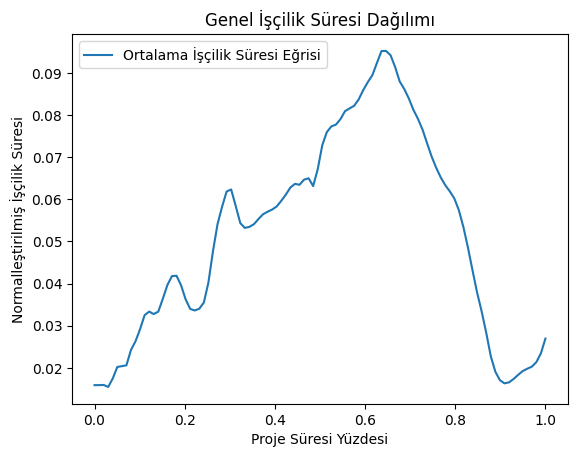

Estimated labor hours for each month of the project:
Month 1: 572.52
Month 2: 560.14
Month 3: 732.20
Month 4: 908.87
Month 5: 1179.82
Month 6: 1216.03
Month 7: 1501.19
Month 8: 1329.12
Month 9: 1219.31
Month 10: 1569.63
Month 11: 2132.36
Month 12: 2085.33
Month 13: 1923.45
Month 14: 2022.43
Month 15: 2087.78
Month 16: 2225.28
Month 17: 2294.58
Month 18: 2284.51
Month 19: 2723.49
Month 20: 2831.80
Month 21: 2948.24
Month 22: 3119.26
Month 23: 3346.47
Month 24: 3383.39
Month 25: 3108.69
Month 26: 2869.26
Month 27: 2577.86
Month 28: 2322.36
Month 29: 2146.12
Month 30: 1738.86
Month 31: 1224.31
Month 32: 728.87
Month 33: 592.01
Month 34: 671.01
Month 35: 736.57
Month 36: 969.77


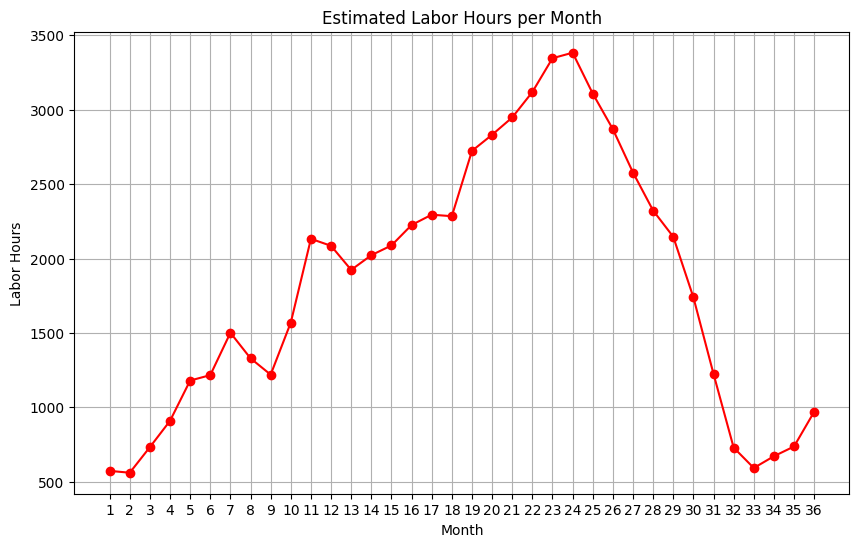

In [ ]:
print("Select the prediction type:")
print("1. New Project")
print("2. Ongoing Project")
choice = input("Enter your choice (1 or 2): ")

if choice == '1':
    project_length = int(input("Enter the total duration of the new project (in months): "))
    total_hours = float(input("Enter total labor hours: "))
    projected_hours = predict_new_project_hours(standardized_data, total_hours, project_length)
elif choice == '2':
    project_length = int(input("Enter the total duration of the ongoing project (in months): "))
    current_month = int(input("Enter the current month of the project: "))
    total_hours = float(input("Enter total labor hours for the project: "))
    hours_spent = float(input("Enter total labor hours spent so far: "))
    projected_hours = predict_ongoing_project_hours(standardized_data, total_hours, project_length, current_month, hours_spent)
else:
    print("Invalid choice. Please select either 1 or 2.")

# Displaying the results
print("Estimated labor hours for each month of the project:")
for month, hours in enumerate(projected_hours, start=1):
    print(f"Month {month}: {hours:.2f}")

# Plotting the results
plot_projected_hours(projected_hours)